In [74]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np
import pandas as pd
import pickle

#### Load stLearn data objects

In [75]:
# Patient samples

# 6747: vis4, cosmx1, 
# 21031: vis2, cosmx2, cosmx3
# 48974: vis1, cosmx4, cosmx5, cosmx6
# 66487: vis3, cosmx7, cosmx8

In [76]:
stlearn = [
    sc.read_h5ad("/scratch/project/stseq/Levi/mmcci_benchmarking/sample1_cci.h5ad"),
    sc.read_h5ad("/scratch/project/stseq/Levi/mmcci_benchmarking/sample2_cci.h5ad"),
    sc.read_h5ad("/scratch/project/stseq/Levi/mmcci_benchmarking/sample3_cci.h5ad")
]

with open('/scratch/project/stseq/Levi/mmcci_benchmarking/squidpy_sample1.pkl', 'rb') as f:
    squidpy1 = pickle.load(f)

with open('/scratch/project/stseq/Levi/mmcci_benchmarking/squidpy_sample2.pkl', 'rb') as f:
    squidpy2 = pickle.load(f)

with open('/scratch/project/stseq/Levi/mmcci_benchmarking/squidpy_sample3.pkl', 'rb') as f:
    squidpy3 = pickle.load(f)

squidpy_cci = [squidpy1, squidpy2, squidpy3]

stlearn_cci = [sample.uns['per_lr_cci_cell_type'] for sample in stlearn]

In [77]:
stlearn_overalls = [mmcci.it.calculate_overall_interactions(sample) for sample in stlearn_cci]
squidpy_overalls = [mmcci.it.calculate_overall_interactions(sample) for sample in squidpy_cci]

In [78]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
import numpy as np
from matplotlib.patches import Arc, Wedge
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.colors as plt_colors
import matplotlib.cm as cm


def hex2rgb(c):
    return tuple(int(c[i : i + 2], 16) / 256.0 for i in (1, 3, 5))


def polar2xy(r, theta):
    return np.array([r * np.cos(theta), r * np.sin(theta)])


def ChordArc(
    start1=0,
    end1=60,
    start2=180,
    end2=240,
    radius=1.0,
    chordwidth=0.7,
    ax=None,
    color=(1, 0, 0),
):
    # start, end should be in [0, 360)
    if start1 > end1:
        start1, end1 = end1, start1
    if start2 > end2:
        start2, end2 = end2, start2
    start1 *= np.pi / 180.0
    end1 *= np.pi / 180.0
    start2 *= np.pi / 180.0
    end2 *= np.pi / 180.0
    opt1 = 4.0 / 3.0 * np.tan((end1 - start1) / 4.0) * radius
    opt2 = 4.0 / 3.0 * np.tan((end2 - start2) / 4.0) * radius
    rchord = radius * (1 - chordwidth)
    verts = [
        polar2xy(radius, start1),
        polar2xy(radius, start1) + polar2xy(opt1, start1 + 0.5 * np.pi),
        polar2xy(radius, end1) + polar2xy(opt1, end1 - 0.5 * np.pi),
        polar2xy(radius, end1),
        polar2xy(rchord, end1),
        polar2xy(rchord, start2),
        polar2xy(radius, start2),
        polar2xy(radius, start2) + polar2xy(opt2, start2 + 0.5 * np.pi),
        polar2xy(radius, end2) + polar2xy(opt2, end2 - 0.5 * np.pi),
        polar2xy(radius, end2),
        polar2xy(rchord, end2),
        polar2xy(rchord, start1),
        polar2xy(radius, start1),
    ]

    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
    ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(
            path, facecolor=color + (0.5,), edgecolor=color + (0.4,), lw=0.3
        )
        ax.add_patch(patch)


def selfChordArc(start=0, end=60, radius=1.0, chordwidth=0.7, ax=None, color=(1, 0, 0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi / 180.0
    end *= np.pi / 180.0
    opt = 4.0 / 3.0 * np.tan((end - start) / 4.0) * radius
    rchord = radius * (1 - chordwidth)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start + 0.5 * np.pi),
        polar2xy(radius, end) + polar2xy(opt, end - 0.5 * np.pi),
        polar2xy(radius, end),
        polar2xy(rchord, end),
        polar2xy(rchord, start),
        polar2xy(radius, start),
    ]

    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
    ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(
            path, facecolor=color + (0.5,), edgecolor=color + (0.4,), lw=0.3
        )
        ax.add_patch(patch)



def chordDiagram(X, ax, colors=None, width=0.1, pad=2, chordwidth=0.7, lim=1.1):
    """Plot a chord diagram
    Parameters
    ----------
    X :
        flux data, X[i, j] is the flux from i to j
    ax :
        matplotlib `axes` to show the plot
    colors : optional
        user defined colors in rgb format. Use function hex2rgb() to convert hex color to rgb color. Default: d3.js category10
    width : optional
        width/thickness of the ideogram arc
    pad : optional
        gap pad between two neighboring ideogram arcs, unit: degree, default: 2 degree
    chordwidth : optional
        position of the control points for the chords, controlling the shape of the chords
    """
    # X[i, j]:  i -> j
    x = X.sum(axis=1)  # sum over rows
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    diam = 1.8

    if colors is None:
        # use d3.js category10 https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category10
        colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
        if len(x) > 10:
            print("x is too large! Use x smaller than 10")
    if type(colors[0]) == str:
        colors = [hex2rgb(colors[i]) for i in range(len(x))]

    # find position for each start and end
    y = x / np.sum(x).astype(float) * (360 - pad * len(x))

    pos = {}
    arc = []
    nodePos = []
    start = 0
    for i in range(len(x)):
        end = start + y[i]
        arc.append((start, end))
        angle = 0.5 * (start + end)
        # print(start, end, angle)
        if -30 <= angle <= 210:
            angle -= 90
        else:
            angle -= 270
        nodePos.append(
            tuple(
                polar2xy((diam / 2) + diam * 0.05, 0.5 * (start + end) * np.pi / 180.0)
            )
            + (angle,)
        )
        z = (X[i, :] / x[i].astype(float)) * (end - start)
        ids = np.argsort(z)
        z0 = start
        for j in ids:
            pos[(i, j)] = (z0, z0 + z[j])
            z0 += z[j]
        start = end + pad

    for i in range(len(x)):
        start, end = arc[i]
        # This draws the outter ring #
        # IdeogramArc(start=start, end=end, radius=1.0, ax=ax,
        #            color=colors[i], width=width)
        a = Arc((0, 0), diam, diam, angle=0, theta1=start, theta2=end, color=colors[i], lw=10)
        ax.add_patch(a)
        start, end = pos[(i, i)]
        # This draws the paths to itself #
        if end - start < 180:  # Indicates this method will work fine !
            selfChordArc(
                start,
                end,
                radius=1.0 - width,
                color=colors[i],
                chordwidth=chordwidth * 0.7,
                ax=ax,
            )
        else:  # Need to use a wedge because the arch distorts past 180-degrees
            path = Wedge(0, diam / 2, start, end, color=colors[i] + (0.5,))
            ax.add_patch(path)
        for j in range(i):
            if X[i, j] == 0 and X[j, i] == 0:  # don't draw anything for no interaction
                continue
            color = colors[i]
            if X[i, j] > X[j, i]:  # Color by the dominant signal #
                color = colors[j]
            start1, end1 = pos[(i, j)]
            start2, end2 = pos[(j, i)]
            ChordArc(
                start1,
                end1,
                start2,
                end2,
                radius=1.0 - width,
                color=color,
                chordwidth=chordwidth,
                ax=ax,
            )

    return nodePos


def chord_plot(network, min_ints=2, n_top_ccis=10,
              cmap='default', show=True,
              sig_interactions=True, title=None, label_size=10,
				  ):
    network = network.transpose()
    fig = plt.figure(figsize=(8, 8))

    flux = network.values
    total_ints = flux.sum(axis=1) + flux.sum(axis=0) - flux.diagonal()
    keep = total_ints > min_ints
    # # Limit of 10 for good display #
    # if sum(keep) > n_top_ccis:
    #     keep = np.argsort(-total_ints)[0:n_top_ccis]
    # flux = flux[:, keep]
    # flux = flux[keep, :].astype(float)
    # cell_names = network.index.values.astype(str)[keep]
    cell_names = network.index.values.astype(str)

    # print(cell_names)
    nodes = cell_names

    # Retrieving colors of cell types #
    # colors = get_colors(adata, use_label, cmap=cmap, label_set=cell_names)

    ax = plt.axes([0, 0, 1, 1])
    nodePos = chordDiagram(flux, ax, lim=1.25)
    ax.axis('off')
    prop = dict(fontsize=label_size, ha='center', va='center')
    for i in range(len(cell_names)):
        x, y = nodePos[i][0:2]
        ax.text(x, y, nodes[i],
                rotation=nodePos[i][2], **prop)
    fig.suptitle(title, fontsize=12, fontweight='bold')
    if show:
        plt.show()
    else:
        return fig, ax

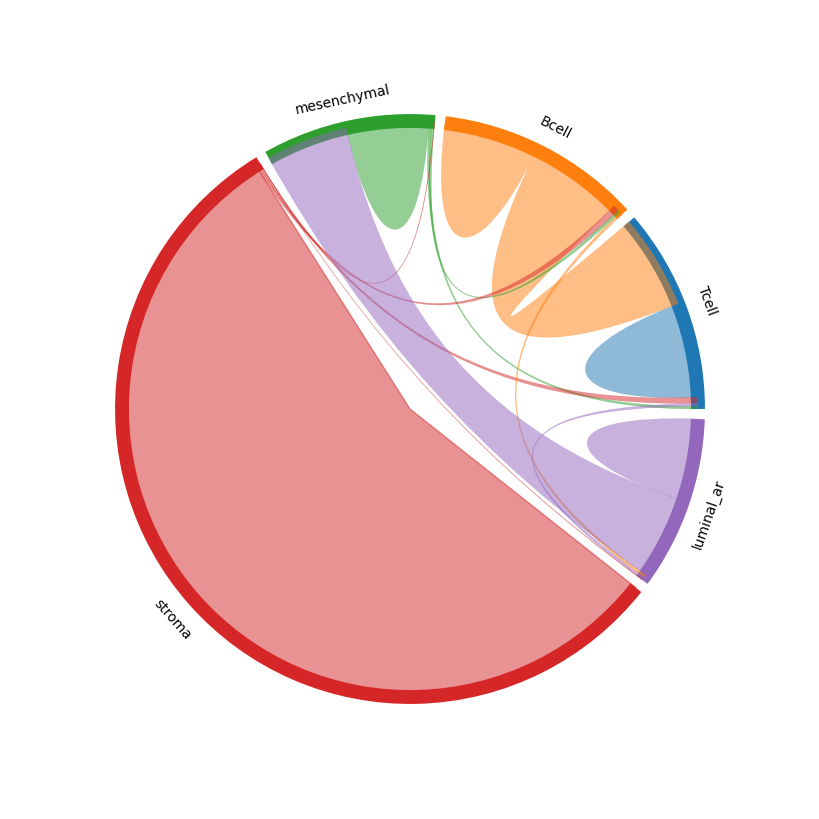

In [79]:
chord_plot(stlearn_overall)

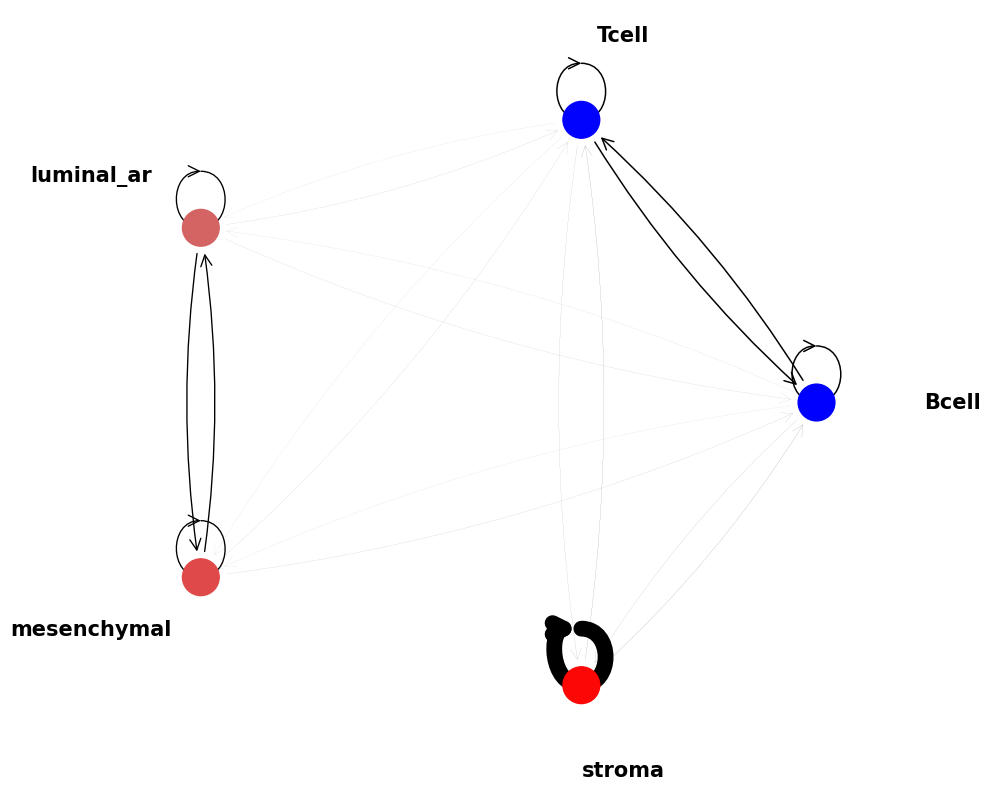

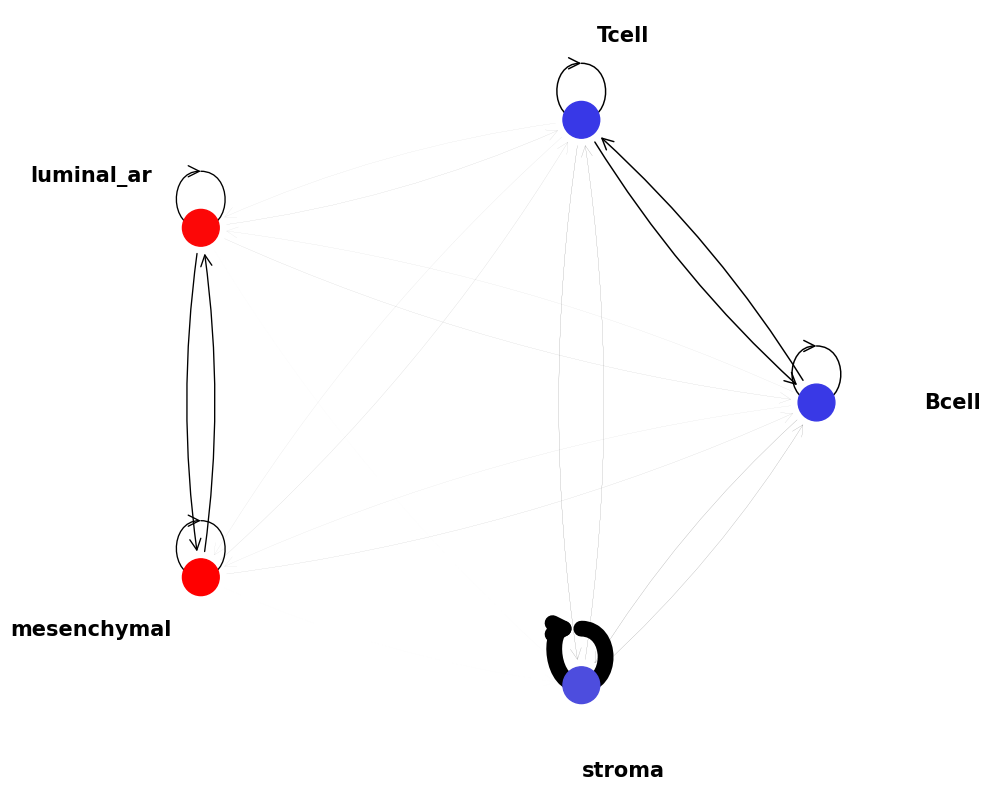

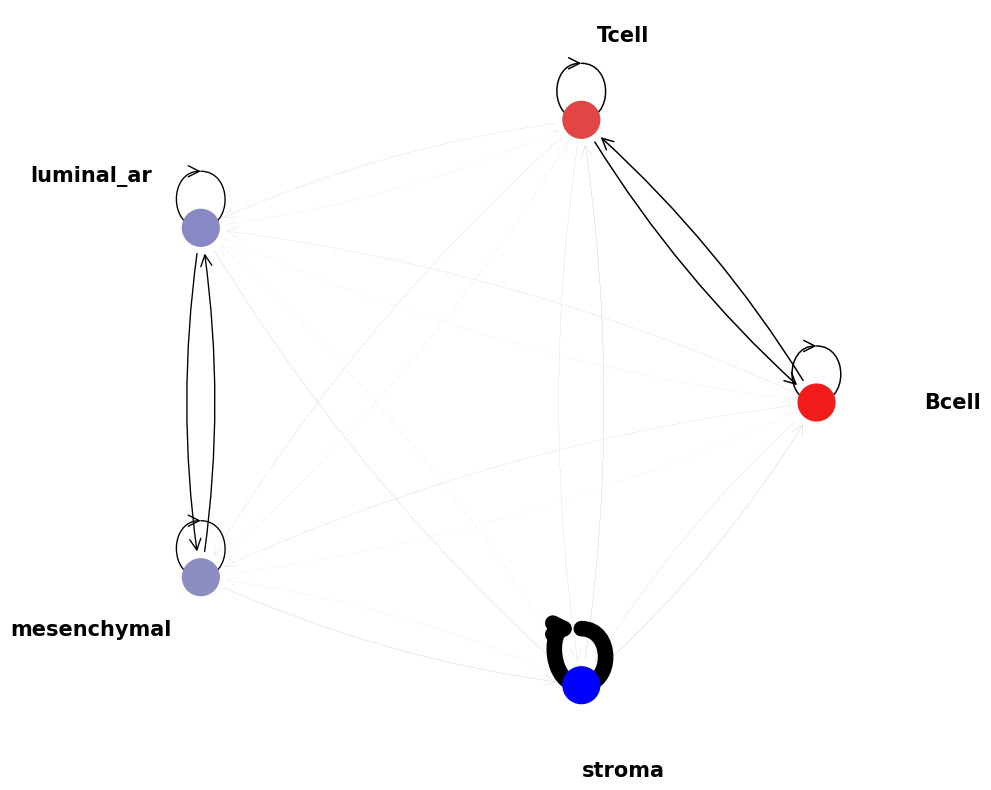

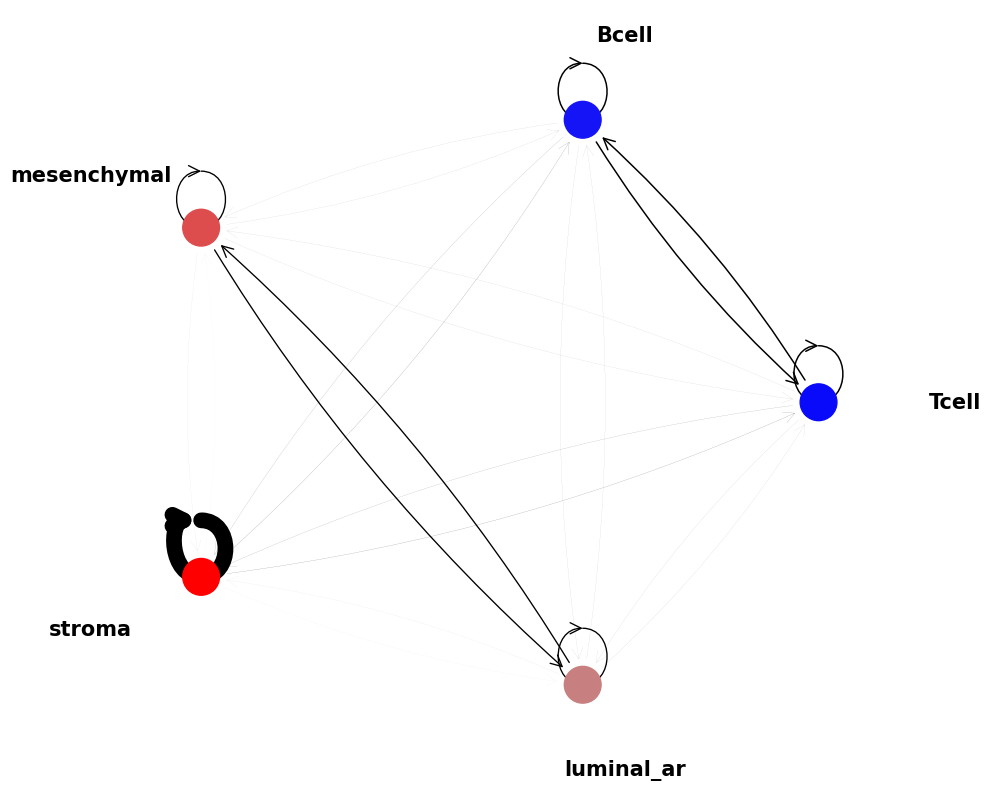

In [80]:
mmcci.plt.network_plot(stlearn_overalls[0])
mmcci.plt.network_plot(stlearn_overalls[1])
mmcci.plt.network_plot(stlearn_overalls[2])

lr_pairs = mmcci.it.get_majority_lr_pairs(stlearn_cci)
stlearn_avg = mmcci.it.get_avg_lr_pairs(stlearn_cci, lr_pairs)
stlearn_overall = mmcci.it.calculate_overall_interactions(stlearn_avg)
mmcci.plt.network_plot(stlearn_overall)

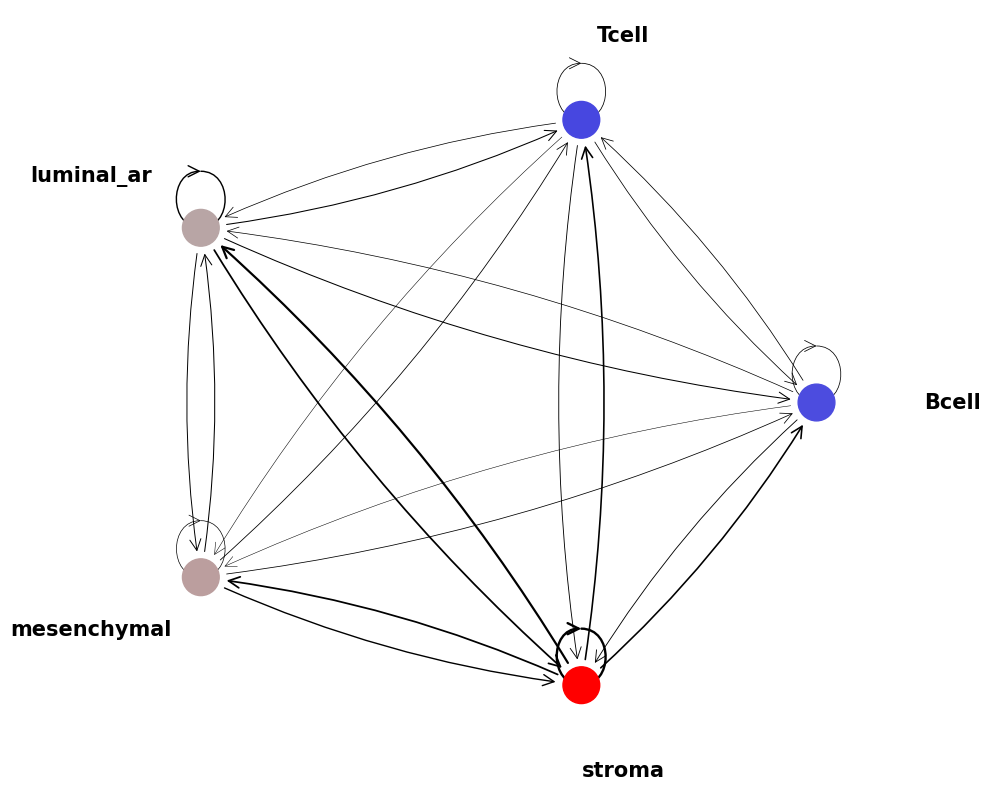

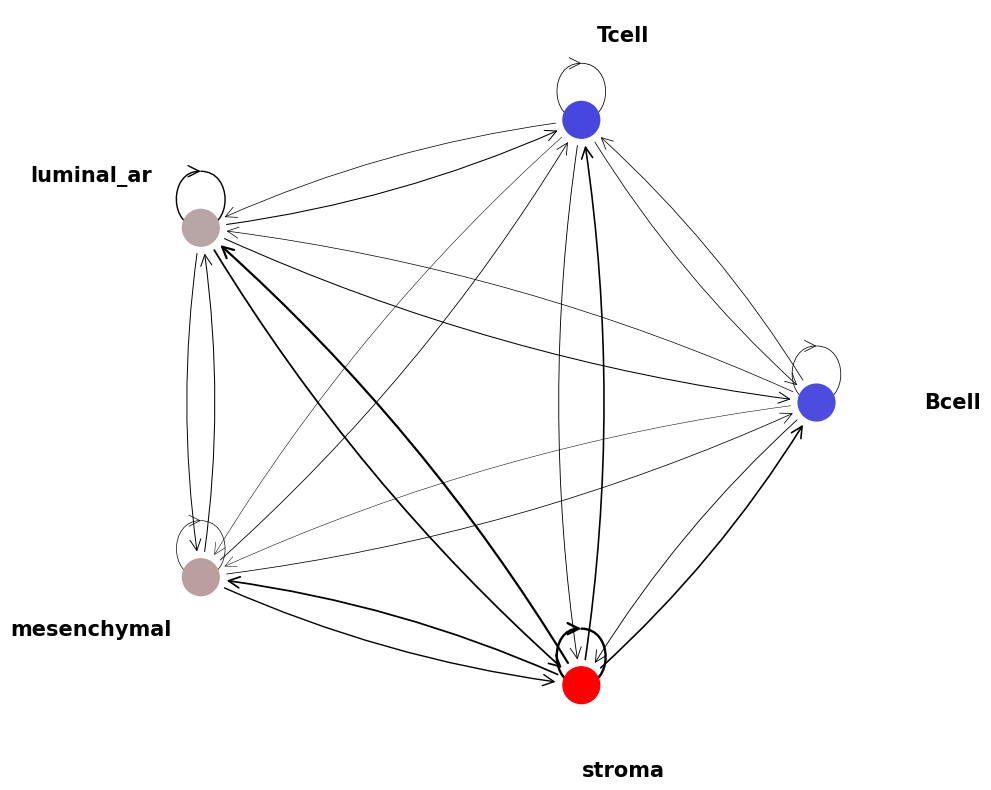

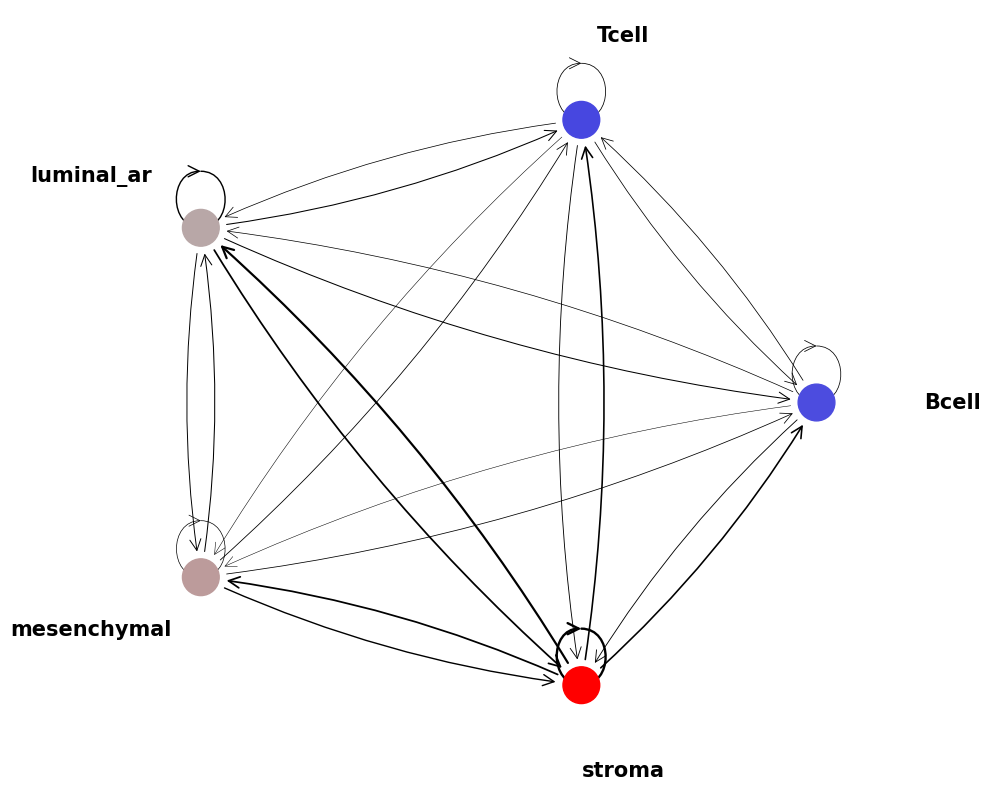

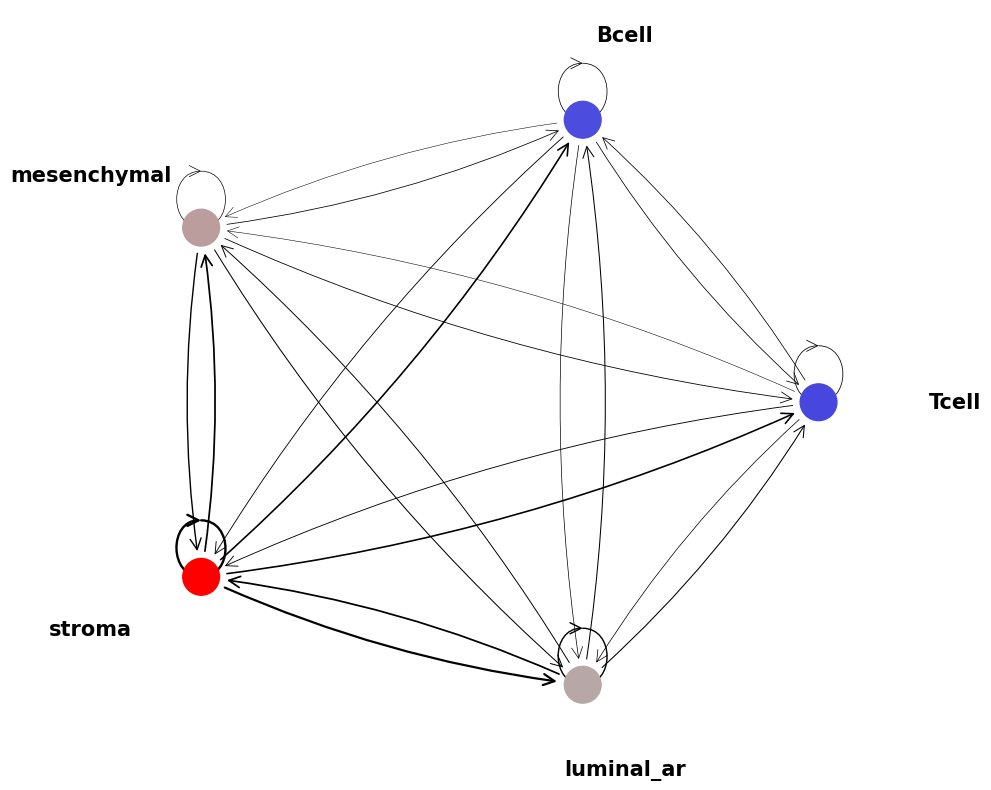

In [81]:
mmcci.plt.network_plot(squidpy_overalls[0])
mmcci.plt.network_plot(squidpy_overalls[1])
mmcci.plt.network_plot(squidpy_overalls[2])

lr_pairs = mmcci.it.get_majority_lr_pairs(squidpy_cci)
squidpy_avg = mmcci.it.get_avg_lr_pairs(squidpy_cci, lr_pairs)
squidpy_overall = mmcci.it.calculate_overall_interactions(squidpy_avg)
mmcci.plt.network_plot(squidpy_overall)